# Capstone project - _Data Daddy_
##### Note to reader: this is all hypothetical

### Introduction

Data Daddy, established by Sir Daniele Capraro, is a company that provides all data analytics outsourcing needs. Established in 2009, Data Daddy was originally focused on the financial institutions and successfully worked with and developed bespoke models to assist these companies during and post financial crisis. Throughout the 2010s, Data Daddy was established as a leader for in Financial industry. With this reputation, towards the end of 2019, Data Daddy attempted to branch out into industries, however, this evolution was halted due to COVID19 (#TotallyRelevant).

With COVID19 eradicated 6 months ago, we are seeing people re-enter the workforce, unemployment rates dropping, and the general public’s “willingness” to spend is rapidly increasing back to normal. For Data Daddy, this influx translates spike in demand, and the need to open a new San Francisco office.

This report will determine the optimal neighbourhood in San Francisco to open a new branch.

### Data

In a prior project, in anticipation for opening a new San Francisco office, all 345 Data Daddy employees were asked to fill out a questionnaire, rating on a 5 point likert scale, which aspect of their job is tied to their job satisfaction. A quick analysis showed the overwhelming majority of employees associated their job satisfaction with local places to eat. See Figure 1 below.

#### Table 1 - Average result of job satisfaction survery

In [46]:
import pandas as pd

data = {'Question':  ['Q1 - I appreciate  the guidance I receive from my manager','Q2 - I enjoy the nature of the work','Q3 - I enjoy a variety of local places to eat','Q4 - I like the set up of the office ','Q5 - The weather affectes my job satisfaction'],
        'Average rating': [3.89,3.71,4.47,3.22,1.87]
        }

df_survey = pd.DataFrame (data, columns = ['Question','Average rating'])
df_survey

,Question,Average rating
0,Q1 - I appreciate the guidance I receive from...,3.89
1,Q2 - I enjoy the nature of the work,3.71
2,Q3 - I enjoy a variety of local places to eat,4.47
3,Q4 - I like the set up of the office,3.22
4,Q5 - The weather affectes my job satisfaction,1.87


#### Table 2 - Frequency count of "Q3 - I enjoy a variety of local places to eat" rating

In [61]:
import pandas as pd

data = {'Q3 - I enjoy a variety of local places to eat':  ['Strongly Disagree','Disagree','Indifferent','Agree','Strongly Agree'],
        'Frequency': [2,16,23,80,224]
        }

df_Q3survey = pd.DataFrame (data, columns = ['Q3 - I enjoy a variety of local places to eat','Frequency'])

Percentage = df_Q3survey['Frequency']/df_Q3survey['Frequency'].sum()

df_Q3survey['Percentage'] = (Percentage*100).round(0)

df_Q3survey

,Q3 - I enjoy a variety of local places to eat,Frequency,Percentage
0,Strongly Disagree,2,1.0
1,Disagree,16,5.0
2,Indifferent,23,7.0
3,Agree,80,23.0
4,Strongly Agree,224,65.0


With 88% of Data Daddy employees agree/strongly agreeing to local places to eat job satisfaction, the free text section of this questionnarie uncovered Data Daddy employees all cited pizza in this section, where:
- Employees enjoy the eating pizza for lunch,
- Employees enjoy ordering pizza for social work events, and 
- Employees enjoy their clients taking them out to pizzerias.

With the number of places selling pizza as the primary driver in Data Daddy employees job satisfaction, we will leverage off Foursquare data to determine the optimal neighborhood to open a new Data Daddy branch.
###### Please note: San Francisco neighbourhood are: Central, Southern, Bayview, Mission, Park, Richmond, Ingleside, Taraval, Northern, and, Tenderloin.

We would assume the Central neighbourbood to have the most pizzerias.

Data we will be extracting from Foursquare is the number of places that sell pizza in San Francisco
We will use this to display the pizza restaurant density by neighborhood through a choropleth graph.

One limitation for Foursquare is that I am not able to extract all the restaurants that sell pizza in one go. To get around this, I will extract the 50 closest restaurants that sell pizza for each neighborhood, and remove any duplicates for restarutants that have been returned multiple times

#### Importing relevant libaraies to extract data from the Foursquare API

In [10]:
import requests
import pandas as pd
import numpy as np 
import random 

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library

print('Folium installed')
print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geopy-1.22.0               |     pyh9f0ad1d_0          63 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    certifi-2020.4.5.1         |   py36h9f0ad1d_0         151 KB  conda-forge
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    ca-certificates-2020.4.5.1 |       hecc5488_0         146 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0           conda-forge
    geopy:          

In [11]:
LIMIT = 200

from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://media.giphy.com/media/dlPvw75axg13O/giphy.gif")

In [12]:
# Constant parameters we are going to use for all Foursquare API calls
CLIENT_ID = 'SCO35RNPJVO2211NLI20ECI3SVSCMNZUTT2SHOFPQZLIFHNO' # your Foursquare ID
CLIENT_SECRET = 'HICE3EL4DS1CLD3CJXNNKHUANGA1Z1Y4JPZ0FOGFLXYJMLGP' # your Foursquare Secret
VERSION = '20180604'

search_query = 'pizza'
radius = 5000
print(search_query + ' .... OK!')

pizza .... OK!


In [13]:
# defining a function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

#### Bayview

In [14]:
# Bayview
latitude = 37.7304
longitude = -122.3844
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)

In [15]:
results_bayview = requests.get(url).json()

# assign relevant part of JSON to venues
venues_bayview = results_bayview['response']['venues']

# tranform venues into a dataframe
df_bayview = json_normalize(venues_bayview)

# keep only columns that include venue name, and anything that is associated with location
filtered_columns_bayview = ['name', 'categories'] + [col for col in df_bayview.columns if col.startswith('location.')] + ['id']
df_bayview_filtered = df_bayview.loc[:, filtered_columns_bayview]

# filter the category for each row
df_bayview_filtered['categories'] = df_bayview_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
df_bayview_filtered.columns = [column.split('.')[-1] for column in df_bayview_filtered.columns]

df_bayview_filtered.head(5)

,name,categories,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,neighborhood,postalCode,state,id
0,Pizza Joint,Pizza Place,2414 San Bruno Ave,US,San Francisco,United States,Silver Ave,1867,"[2414 San Bruno Ave (Silver Ave), San Francisc...","[{'label': 'display', 'lat': 37.73206410139971...",37.732064,-122.405506,NaN,94134,CA,4af1e518f964a52034e421e3
1,Cellarmaker House of Pizza,Brewery,3193 Mission St,US,San Francisco,United States,Fair St,3548,"[3193 Mission St (Fair St), San Francisco, CA ...","[{'label': 'display', 'lat': 37.74573858325575...",37.745739,-122.419737,Bernal Heights,94110,CA,5c37fbb3610f04002c72e497
2,Round Table Pizza,Pizza Place,2660 San Bruno Ave,US,San Francisco,United States,btwn Bacon & Burrows,1733,"[2660 San Bruno Ave (btwn Bacon & Burrows), Sa...","[{'label': 'display', 'lat': 37.72799629961786...",37.727996,-122.403855,NaN,94134,CA,4c361c282c8020a107c38600
3,Little Star Pizza,Pizza Place,400 Valencia St,US,San Francisco,United States,at 15th St,5205,"[400 Valencia St (at 15th St), San Francisco, ...","[{'label': 'display', 'lat': 37.76643791899293...",37.766438,-122.422078,NaN,94103,CA,4537f9daf964a520c73b1fe3
4,Goat Hill Pizza,Pizza Place,300 Connecticut St,US,San Francisco,United States,at 18th St,3751,"[300 Connecticut St (at 18th St), San Francisc...","[{'label': 'display', 'lat': 37.7624335055108,...",37.762434,-122.397654,NaN,94107,CA,413e4b80f964a520521c1fe3


#### Central

In [16]:
# Central
latitude = 37.7720
longitude = -122.4220
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)

In [17]:
results_central = requests.get(url).json()

# assign relevant part of JSON to venues
venues_central = results_central['response']['venues']

# tranform venues into a dataframe
df_central = json_normalize(venues_central)

# keep only columns that include venue name, and anything that is associated with location
filtered_columns_central = ['name', 'categories'] + [col for col in df_central.columns if col.startswith('location.')] + ['id']
df_central_filtered = df_central.loc[:, filtered_columns_central]

# filter the category for each row
df_central_filtered['categories'] = df_central_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
df_central_filtered.columns = [column.split('.')[-1] for column in df_central_filtered.columns]

df_central_filtered.head(5)

,name,categories,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,neighborhood,postalCode,state,id
0,Little Star Pizza,Pizza Place,400 Valencia St,US,San Francisco,United States,at 15th St,619,"[400 Valencia St (at 15th St), San Francisco, ...","[{'label': 'display', 'lat': 37.76643791899293...",37.766438,-122.422078,NaN,94103,CA,4537f9daf964a520c73b1fe3
1,Pizza Zone 'N' Grill,Pizza Place,178 Valencia St,US,San Francisco,United States,Duboce,206,"[178 Valencia St (Duboce), San Francisco, CA 9...","[{'label': 'display', 'lat': 37.7701723314246,...",37.770172,-122.422390,NaN,94103,CA,4a2f4ceff964a520bf981fe3
2,Patxi's Chicago Pizza,Pizza Place,511 Hayes St,US,San Francisco,United States,btwn Octavia St & Laguna St,567,"[511 Hayes St (btwn Octavia St & Laguna St), S...","[{'label': 'display', 'lat': 37.77654873335434...",37.776549,-122.424917,NaN,94102,CA,43d7e5dff964a5205d2e1fe3
3,Arinell Pizza,Pizza Place,509 Valencia St,US,San Francisco,United States,at 16th St.,805,"[509 Valencia St (at 16th St.), San Francisco,...","[{'label': 'display', 'lat': 37.76476856685304...",37.764769,-122.421865,NaN,94110,CA,436e9900f964a520e9291fe3
4,Little Star Pizza,Pizza Place,846 Divisadero St,US,San Francisco,United States,btwn Mcallister St & Fulton St,1557,[846 Divisadero St (btwn Mcallister St & Fulto...,"[{'label': 'display', 'lat': 37.77748853090511...",37.777489,-122.438281,NaN,94117,CA,433dd180f964a52048281fe3


#### Ingleside 

In [18]:
# Ingleside
latitude = 37.7198
longitude = -122.4538
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
results = requests.get(url).json()

In [19]:
results_ingleside = requests.get(url).json()

# assign relevant part of JSON to venues
venues_ingleside = results_ingleside['response']['venues']

# tranform venues into a dataframe
df_ingleside = json_normalize(venues_ingleside)

# keep only columns that include venue name, and anything that is associated with location
filtered_columns_ingleside = ['name', 'categories'] + [col for col in df_ingleside.columns if col.startswith('location.')] + ['id']
df_ingleside_filtered = df_ingleside.loc[:, filtered_columns_ingleside]

# filter the category for each row
df_ingleside_filtered['categories'] = df_ingleside_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
df_ingleside_filtered.columns = [column.split('.')[-1] for column in df_ingleside_filtered.columns]

df_ingleside_filtered.head(5)

,name,categories,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,neighborhood,postalCode,state,id
0,Ocean Pizza,Pizza Place,1443 Ocean Ave,US,San Francisco,United States,NaN,604,"[1443 Ocean Ave, San Francisco, CA 94112, Unit...","[{'label': 'display', 'lat': 37.72414391916352...",37.724144,-122.457911,NaN,94112,CA,4b3d5337f964a5206f9225e3
1,Little Caesars Pizza,Pizza Place,955 Geneva Ave,US,San Francisco,United States,NaN,1276,"[955 Geneva Ave, San Francisco, CA 94112, Unit...","[{'label': 'display', 'lat': 37.71606164247851...",37.716062,-122.440091,NaN,94112,CA,4a37f0d0f964a520959e1fe3
2,Extreme Pizza,Pizza Place,3911 Alemany Blvd,US,San Francisco,United States,behind Daly City Bart,1637,"[3911 Alemany Blvd (behind Daly City Bart), Sa...","[{'label': 'display', 'lat': 37.7099065879788,...",37.709907,-122.467557,NaN,94132,CA,4b0e26d9f964a520635523e3
3,Round Table Pizza,Pizza Place,6222 Mission St,US,Daly City,United States,NaN,1564,"[6222 Mission St, Daly City, CA 94014, United ...","[{'label': 'display', 'lat': 37.70661174927863...",37.706612,-122.459925,NaN,94014,CA,4be4a79cd4f7c9b6c77c2420
4,Bravo's Pizza,Pizza Place,5145 Mission St,US,San Francisco,United States,Geneva,1184,"[5145 Mission St (Geneva), San Francisco, CA 9...","[{'label': 'display', 'lat': 37.71658983673383...",37.716590,-122.440974,NaN,94112,CA,4b064e19f964a52094ea22e3


#### Mission

In [20]:
# Mission
latitude = 37.7599
longitude = -122.4148
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)

In [21]:
results_mission = requests.get(url).json()

# assign relevant part of JSON to venues
venues_mission = results_mission['response']['venues']

# tranform venues into a dataframe
df_mission = json_normalize(venues_mission)

# keep only columns that include venue name, and anything that is associated with location
filtered_columns_mission = ['name', 'categories'] + [col for col in df_mission.columns if col.startswith('location.')] + ['id']
df_mission_filtered = df_mission.loc[:, filtered_columns_mission]

# filter the category for each row
df_mission_filtered['categories'] = df_mission_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
df_mission_filtered.columns = [column.split('.')[-1] for column in df_mission_filtered.columns]

df_mission_filtered.head(5)

,name,categories,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,neighborhood,postalCode,state,id
0,Little Star Pizza,Pizza Place,400 Valencia St,US,San Francisco,United States,at 15th St,969,"[400 Valencia St (at 15th St), San Francisco, ...","[{'label': 'display', 'lat': 37.76643791899293...",37.766438,-122.422078,NaN,94103,CA,4537f9daf964a520c73b1fe3
1,Mr Pizza Man,Pizza Place,2680 22nd St,US,San Francisco,United States,at York St,741,"[2680 22nd St (at York St), San Francisco, CA ...","[{'label': 'display', 'lat': 37.75642953453542...",37.756430,-122.407606,NaN,94110,CA,49d55577f964a520885c1fe3
2,Serrano's Pizza,Pizza Place,3274 21st St,US,San Francisco,United States,at Valencia,607,"[3274 21st St (at Valencia), San Francisco, CA...","[{'label': 'display', 'lat': 37.75697068958007...",37.756971,-122.420628,NaN,94110,CA,46db1a43f964a5207f4a1fe3
3,Arinell Pizza,Pizza Place,509 Valencia St,US,San Francisco,United States,at 16th St.,824,"[509 Valencia St (at 16th St.), San Francisco,...","[{'label': 'display', 'lat': 37.76476856685304...",37.764769,-122.421865,NaN,94110,CA,436e9900f964a520e9291fe3
4,Cellarmaker House of Pizza,Brewery,3193 Mission St,US,San Francisco,United States,Fair St,1635,"[3193 Mission St (Fair St), San Francisco, CA ...","[{'label': 'display', 'lat': 37.74573858325575...",37.745739,-122.419737,Bernal Heights,94110,CA,5c37fbb3610f04002c72e497


#### Northern

In [22]:
# Northern
latitude = 37.7749
longitude = -122.4194
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)

In [23]:
results_northern = requests.get(url).json()

# assign relevant part of JSON to venues
venues_northern = results_northern['response']['venues']

# tranform venues into a dataframe
df_northern = json_normalize(venues_northern)

# keep only columns that include venue name, and anything that is associated with location
filtered_columns_northern = ['name', 'categories'] + [col for col in df_northern.columns if col.startswith('location.')] + ['id']
df_northern_filtered = df_northern.loc[:, filtered_columns_northern]

# filter the category for each row
df_northern_filtered['categories'] = df_northern_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
df_northern_filtered.columns = [column.split('.')[-1] for column in df_northern_filtered.columns]

df_northern_filtered.head(5)

,name,categories,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,neighborhood,postalCode,state,id
0,Little Star Pizza,Pizza Place,400 Valencia St,US,San Francisco,United States,at 15th St,971,"[400 Valencia St (at 15th St), San Francisco, ...","[{'label': 'display', 'lat': 37.76643791899293...",37.766438,-122.422078,NaN,94103,CA,4537f9daf964a520c73b1fe3
1,Patxi's Chicago Pizza,Pizza Place,511 Hayes St,US,San Francisco,United States,btwn Octavia St & Laguna St,518,"[511 Hayes St (btwn Octavia St & Laguna St), S...","[{'label': 'display', 'lat': 37.77654873335434...",37.776549,-122.424917,NaN,94102,CA,43d7e5dff964a5205d2e1fe3
2,Chico’s Pizza,Pizza Place,131 6th St,US,San Francisco,United States,btwn Howard & Mission,1170,"[131 6th St (btwn Howard & Mission), San Franc...","[{'label': 'display', 'lat': 37.78066976185074...",37.780670,-122.408272,NaN,94103,CA,49c9a52df964a5208d581fe3
3,DNA Pizza,Pizza Place,371 11th St,US,San Francisco,United States,at Harrison St,723,"[371 11th St (at Harrison St), San Francisco, ...","[{'label': 'display', 'lat': 37.77096728739858...",37.770967,-122.412849,NaN,94103,CA,4d7448596820ba7ac1e73cfe
4,Pizza Zone 'N' Grill,Pizza Place,178 Valencia St,US,San Francisco,United States,Duboce,588,"[178 Valencia St (Duboce), San Francisco, CA 9...","[{'label': 'display', 'lat': 37.7701723314246,...",37.770172,-122.422390,NaN,94103,CA,4a2f4ceff964a520bf981fe3


#### Park

In [24]:
# Park
latitude = 37.7596
longitude = -122.4269
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)

In [25]:
results_park = requests.get(url).json()

# assign relevant part of JSON to venues
venues_park = results_park['response']['venues']

# tranform venues into a dataframe
df_park = json_normalize(venues_park)

# keep only columns that include venue name, and anything that is associated with location
filtered_columns_park = ['name', 'categories'] + [col for col in df_park.columns if col.startswith('location.')] + ['id']
df_park_filtered = df_park.loc[:, filtered_columns_park]

# filter the category for each row
df_park_filtered['categories'] = df_park_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
df_park_filtered.columns = [column.split('.')[-1] for column in df_park_filtered.columns]

df_park_filtered.head(5)

,name,categories,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,neighborhood,postalCode,state,id
0,Little Star Pizza,Pizza Place,400 Valencia St,US,San Francisco,United States,at 15th St,871,"[400 Valencia St (at 15th St), San Francisco, ...","[{'label': 'display', 'lat': 37.76643791899293...",37.766438,-122.422078,NaN,94103,CA,4537f9daf964a520c73b1fe3
1,Serrano's Pizza,Pizza Place,3274 21st St,US,San Francisco,United States,at Valencia,624,"[3274 21st St (at Valencia), San Francisco, CA...","[{'label': 'display', 'lat': 37.75697068958007...",37.756971,-122.420628,NaN,94110,CA,46db1a43f964a5207f4a1fe3
2,Patxi’s Pizza,Pizza Place,4042 24th St,US,San Francisco,United States,btwn Castro & Noe,1049,"[4042 24th St (btwn Castro & Noe), San Francis...","[{'label': 'display', 'lat': 37.75143034444472...",37.751430,-122.432856,NaN,94114,CA,4cccf2a372106dcb93d79f99
3,Arinell Pizza,Pizza Place,509 Valencia St,US,San Francisco,United States,at 16th St.,726,"[509 Valencia St (at 16th St.), San Francisco,...","[{'label': 'display', 'lat': 37.76476856685304...",37.764769,-122.421865,NaN,94110,CA,436e9900f964a520e9291fe3
4,Cellarmaker House of Pizza,Brewery,3193 Mission St,US,San Francisco,United States,Fair St,1666,"[3193 Mission St (Fair St), San Francisco, CA ...","[{'label': 'display', 'lat': 37.74573858325575...",37.745739,-122.419737,Bernal Heights,94110,CA,5c37fbb3610f04002c72e497


#### Richmond

In [26]:
# Richmond
latitude = 37.7797
longitude = -122.4829
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)

In [27]:
results_richmond = requests.get(url).json()

# assign relevant part of JSON to venues
venues_richmond = results_richmond['response']['venues']

# tranform venues into a dataframe
df_richmond = json_normalize(venues_richmond)

# keep only columns that include venue name, and anything that is associated with location
filtered_columns_richmond = ['name', 'categories'] + [col for col in df_richmond.columns if col.startswith('location.')] + ['id']
df_richmond_filtered = df_richmond.loc[:, filtered_columns_richmond]

# filter the category for each row
df_richmond_filtered['categories'] = df_richmond_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
df_richmond_filtered.columns = [column.split('.')[-1] for column in df_richmond_filtered.columns]

df_richmond_filtered.head(5)

,name,categories,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,neighborhood,postalCode,state,id
0,Gaspare's Pizza,Pizza Place,5546 Geary Blvd,US,San Francisco,United States,at 19th Ave.,336,"[5546 Geary Blvd (at 19th Ave.), San Francisco...","[{'label': 'display', 'lat': 37.78044976362707...",37.780450,-122.479201,NaN,94121,CA,4a63e6e4f964a520fcc51fe3
1,Pizza City,Pizza Place,6905 Geary Blvd,US,San Francisco,United States,33rd avenue,949,"[6905 Geary Blvd (33rd avenue), San Francisco,...","[{'label': 'display', 'lat': 37.77943300000000...",37.779433,-122.493683,NaN,94121,CA,4b689236f964a52085802be3
2,Pasquale's Pizza,Pizza Place,700 Irving St,US,San Francisco,United States,at 8th Ave,2311,"[700 Irving St (at 8th Ave), San Francisco, CA...","[{'label': 'display', 'lat': 37.76418726305658...",37.764187,-122.465436,NaN,94122,CA,3fd66200f964a5202af11ee3
3,Patxi's Pizza,Pizza Place,822 Irving St,US,San Francisco,United States,Btw 9th & 10th,2245,"[822 Irving St (Btw 9th & 10th), San Francisco...","[{'label': 'display', 'lat': 37.76407016725625...",37.764070,-122.466775,NaN,94122,CA,4e9b118202d5df1b507dc9d0
4,Victoria's New York Pizza,Pizza Place,3605 Balboa St,US,San Francisco,United States,at 37th Ave.,1366,"[3605 Balboa St (at 37th Ave.), San Francisco,...","[{'label': 'display', 'lat': 37.77453107196334...",37.774531,-122.496992,NaN,94121,CA,4b1b383bf964a520c4f923e3


#### Southern

In [28]:
# Southern
latitude = 37.6547
longitude = -122.4078
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)

In [29]:
results_southern = requests.get(url).json()

# assign relevant part of JSON to venues
venues_southern = results_southern['response']['venues']

# tranform venues into a dataframe
df_southern = json_normalize(venues_southern)

# keep only columns that include venue name, and anything that is associated with location
filtered_columns_southern = ['name', 'categories'] + [col for col in df_southern.columns if col.startswith('location.')] + ['id']
df_southern_filtered = df_southern.loc[:, filtered_columns_southern]

# filter the category for each row
df_southern_filtered['categories'] = df_southern_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
df_southern_filtered.columns = [column.split('.')[-1] for column in df_southern_filtered.columns]

df_southern_filtered.head(5)

,name,categories,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,postalCode,state,id
0,Cecilia's Pizza & Italian Restaurant,Pizza Place,113 Grand Ave,US,South San Francisco,United States,NaN,65,"[113 Grand Ave, South San Francisco, CA 94080,...","[{'label': 'display', 'lat': 37.654567, 'lng':...",37.654567,-122.408529,94080,CA,4c18312e1436a59377118d75
1,Bravo Pizza,Pizza Place,334 Grand Ave,US,South San Francisco,United States,NaN,273,"[334 Grand Ave, South San Francisco, CA 94080,...","[{'label': 'display', 'lat': 37.655595, 'lng':...",37.655595,-122.410696,94080,CA,4426e5f1f964a520b2311fe3
2,Seniore's Pizza,Pizza Place,730 Kains Ave,US,San Bruno,United States,at Camino Plz,3148,"[730 Kains Ave (at Camino Plz), San Bruno, CA ...","[{'label': 'display', 'lat': 37.62726305960847...",37.627263,-122.416454,94066,CA,5611e2e2498e55bb5430abbb
3,Papa Joe's Pizza / Mexican,Pizza Place,415 Linden Ave,US,South San Francisco,United States,NaN,558,"[415 Linden Ave, South San Francisco, CA 94080...","[{'label': 'display', 'lat': 37.64986918699188...",37.649869,-122.406085,94080,CA,4f08d961e4b071c575fa9ad9
4,Pie Five Pizza,Pizza Place,Terminal 3,US,San Francisco,United States,SFO Airport,4229,"[Terminal 3 (SFO Airport), San Francisco, CA 9...","[{'label': 'display', 'lat': 37.62007865903975...",37.620079,-122.388038,94128,CA,5afb9de0ff0306002c760138


#### Taraval

In [30]:
# Taraval
latitude = 37.7739
longitude = -122.4313
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)

In [31]:
results_taraval = requests.get(url).json()

# assign relevant part of JSON to venues
venues_taraval = results_taraval['response']['venues']

# tranform venues into a dataframe
df_taraval = json_normalize(venues_taraval)

# keep only columns that include venue name, and anything that is associated with location
filtered_columns_taraval = ['name', 'categories'] + [col for col in df_taraval.columns if col.startswith('location.')] + ['id']
df_taraval_filtered = df_taraval.loc[:, filtered_columns_taraval]

# filter the category for each row
df_taraval_filtered['categories'] = df_taraval_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
df_taraval_filtered.columns = [column.split('.')[-1] for column in df_taraval_filtered.columns]

df_taraval_filtered.head(5)

,name,categories,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,neighborhood,postalCode,state,id
0,Little Star Pizza,Pizza Place,846 Divisadero St,US,San Francisco,United States,btwn Mcallister St & Fulton St,732,[846 Divisadero St (btwn Mcallister St & Fulto...,"[{'label': 'display', 'lat': 37.77748853090511...",37.777489,-122.438281,NaN,94117,CA,433dd180f964a52048281fe3
1,Little Star Pizza,Pizza Place,400 Valencia St,US,San Francisco,United States,at 15th St,1161,"[400 Valencia St (at 15th St), San Francisco, ...","[{'label': 'display', 'lat': 37.76643791899293...",37.766438,-122.422078,NaN,94103,CA,4537f9daf964a520c73b1fe3
2,Mythic Pizza,Pizza Place,551 Haight St,US,San Francisco,United States,btwn Steiner & Fillmore St.,214,"[551 Haight St (btwn Steiner & Fillmore St.), ...","[{'label': 'display', 'lat': 37.77197428503029...",37.771974,-122.431284,NaN,94117,CA,44c6a6f9f964a520df351fe3
3,Patxi's Chicago Pizza,Pizza Place,511 Hayes St,US,San Francisco,United States,btwn Octavia St & Laguna St,634,"[511 Hayes St (btwn Octavia St & Laguna St), S...","[{'label': 'display', 'lat': 37.77654873335434...",37.776549,-122.424917,NaN,94102,CA,43d7e5dff964a5205d2e1fe3
4,Bus Stop Pizza,Pizza Place,256 Divisadero St,US,San Francisco,United States,Haight St,577,"[256 Divisadero St (Haight St), San Francisco,...","[{'label': 'display', 'lat': 37.77149682287828...",37.771497,-122.437113,NaN,94117,CA,49f48658f964a520146b1fe3


#### Tenderloin

In [32]:
# Tenderloin
latitude = 37.7304
longitude = -122.3844
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)

In [33]:
results_tenderloin = requests.get(url).json()

# assign relevant part of JSON to venues
venues_tenderloin = results_tenderloin['response']['venues']

# tranform venues into a dataframe
df_tenderloin = json_normalize(venues_tenderloin)

# keep only columns that include venue name, and anything that is associated with location
filtered_columns_tenderloin = ['name', 'categories'] + [col for col in df_tenderloin.columns if col.startswith('location.')] + ['id']
df_tenderloin_filtered = df_tenderloin.loc[:, filtered_columns_tenderloin]

# filter the category for each row
df_tenderloin_filtered['categories'] = df_tenderloin_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
df_tenderloin_filtered.columns = [column.split('.')[-1] for column in df_tenderloin_filtered.columns]

df_tenderloin_filtered.head(5)

,name,categories,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,neighborhood,postalCode,state,id
0,Pizza Joint,Pizza Place,2414 San Bruno Ave,US,San Francisco,United States,Silver Ave,1867,"[2414 San Bruno Ave (Silver Ave), San Francisc...","[{'label': 'display', 'lat': 37.73206410139971...",37.732064,-122.405506,NaN,94134,CA,4af1e518f964a52034e421e3
1,Cellarmaker House of Pizza,Brewery,3193 Mission St,US,San Francisco,United States,Fair St,3548,"[3193 Mission St (Fair St), San Francisco, CA ...","[{'label': 'display', 'lat': 37.74573858325575...",37.745739,-122.419737,Bernal Heights,94110,CA,5c37fbb3610f04002c72e497
2,Round Table Pizza,Pizza Place,2660 San Bruno Ave,US,San Francisco,United States,btwn Bacon & Burrows,1733,"[2660 San Bruno Ave (btwn Bacon & Burrows), Sa...","[{'label': 'display', 'lat': 37.72799629961786...",37.727996,-122.403855,NaN,94134,CA,4c361c282c8020a107c38600
3,Little Star Pizza,Pizza Place,400 Valencia St,US,San Francisco,United States,at 15th St,5205,"[400 Valencia St (at 15th St), San Francisco, ...","[{'label': 'display', 'lat': 37.76643791899293...",37.766438,-122.422078,NaN,94103,CA,4537f9daf964a520c73b1fe3
4,Goat Hill Pizza,Pizza Place,300 Connecticut St,US,San Francisco,United States,at 18th St,3751,"[300 Connecticut St (at 18th St), San Francisc...","[{'label': 'display', 'lat': 37.7624335055108,...",37.762434,-122.397654,NaN,94107,CA,413e4b80f964a520521c1fe3


#### Appending dataframes and removing duplicate restaurants

In [119]:
df = df_tenderloin_filtered.append([df_bayview_filtered,df_central_filtered,df_ingleside_filtered,df_mission_filtered,df_northern_filtered,df_park_filtered,df_richmond_filtered,df_southern_filtered,df_taraval_filtered])
df.describe()

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


,distance,lat,lng
count,494.000000,494.000000,494.000000
mean,2661.874494,37.751770,-122.427540
std,1545.402763,0.040449,0.023392
min,59.000000,37.609080,-122.505533
25%,1355.500000,37.742801,-122.436974
50%,2376.000000,37.763460,-122.422078
75%,3789.000000,37.776549,-122.411602
max,6563.000000,37.804328,-122.383439


In [35]:
df = df.drop_duplicates(subset = 'id', keep='first')

In [36]:
df.describe()

,distance,lat,lng
count,190.000000,190.000000,190.000000
mean,2678.431579,37.731950,-122.432243
std,1543.755951,0.054223,0.028518
min,65.000000,37.609080,-122.505533
25%,1407.750000,37.707529,-122.453064
50%,2444.000000,37.752042,-122.424705
75%,3865.750000,37.772368,-122.411263
max,5913.000000,37.804328,-122.383439


In [37]:
print('there are',df['lat'].count(),'unique pizza restaurants')

there are 190 unique pizza restaurants


In [38]:
df.head(5)

,address,categories,cc,city,country,crossStreet,distance,formattedAddress,id,labeledLatLngs,lat,lng,name,neighborhood,postalCode,state
0,2414 San Bruno Ave,Pizza Place,US,San Francisco,United States,Silver Ave,1867,"[2414 San Bruno Ave (Silver Ave), San Francisc...",4af1e518f964a52034e421e3,"[{'label': 'display', 'lat': 37.73206410139971...",37.732064,-122.405506,Pizza Joint,NaN,94134,CA
1,3193 Mission St,Brewery,US,San Francisco,United States,Fair St,3548,"[3193 Mission St (Fair St), San Francisco, CA ...",5c37fbb3610f04002c72e497,"[{'label': 'display', 'lat': 37.74573858325575...",37.745739,-122.419737,Cellarmaker House of Pizza,Bernal Heights,94110,CA
2,2660 San Bruno Ave,Pizza Place,US,San Francisco,United States,btwn Bacon & Burrows,1733,"[2660 San Bruno Ave (btwn Bacon & Burrows), Sa...",4c361c282c8020a107c38600,"[{'label': 'display', 'lat': 37.72799629961786...",37.727996,-122.403855,Round Table Pizza,NaN,94134,CA
3,400 Valencia St,Pizza Place,US,San Francisco,United States,at 15th St,5205,"[400 Valencia St (at 15th St), San Francisco, ...",4537f9daf964a520c73b1fe3,"[{'label': 'display', 'lat': 37.76643791899293...",37.766438,-122.422078,Little Star Pizza,NaN,94103,CA
4,300 Connecticut St,Pizza Place,US,San Francisco,United States,at 18th St,3751,"[300 Connecticut St (at 18th St), San Francisc...",413e4b80f964a520521c1fe3,"[{'label': 'display', 'lat': 37.7624335055108,...",37.762434,-122.397654,Goat Hill Pizza,NaN,94107,CA


#### Classifying each restaurant to their correct neighborhood

In [39]:
# The code was removed by Watson Studio for sharing.

,District,MinLong,MaxLong,MinLat,MaxLat
0,CENTRAL,-122.426850,-122.392919,37.786023,37.811575
1,SOUTHERN,-122.426402,-122.384341,37.766060,37.797949
2,BAYVIEW,-122.419533,-122.356983,37.708363,37.776807
3,MISSION,-122.445087,-122.402884,37.745224,37.770348
4,PARK,-122.464416,-122.431187,37.743055,37.784333


In [40]:
for key, district in df2.groupby('District'):
    
    cols = ['MinLat','MaxLat','MinLong','MaxLong']
    
    masks = (df['lat'].between(MinLat,MaxLat) & \
             df['lng'].between(MinLong,MaxLong) \
            for MinLat, MaxLat,MinLong,MaxLong in \
            district[cols].itertuples(index=False))
    
    df.loc[pd.concat(masks, axis=1).any(1),'District'] = key
    
df['District'] = df['District'].fillna('CENTRAL')
df['District'].replace('Unknown','CENTRAL',inplace=True)
df.head(5)

,address,categories,cc,city,country,crossStreet,distance,formattedAddress,id,labeledLatLngs,lat,lng,name,neighborhood,postalCode,state,District
0,2414 San Bruno Ave,Pizza Place,US,San Francisco,United States,Silver Ave,1867,"[2414 San Bruno Ave (Silver Ave), San Francisc...",4af1e518f964a52034e421e3,"[{'label': 'display', 'lat': 37.73206410139971...",37.732064,-122.405506,Pizza Joint,NaN,94134,CA,INGLESIDE
1,3193 Mission St,Brewery,US,San Francisco,United States,Fair St,3548,"[3193 Mission St (Fair St), San Francisco, CA ...",5c37fbb3610f04002c72e497,"[{'label': 'display', 'lat': 37.74573858325575...",37.745739,-122.419737,Cellarmaker House of Pizza,Bernal Heights,94110,CA,MISSION
2,2660 San Bruno Ave,Pizza Place,US,San Francisco,United States,btwn Bacon & Burrows,1733,"[2660 San Bruno Ave (btwn Bacon & Burrows), Sa...",4c361c282c8020a107c38600,"[{'label': 'display', 'lat': 37.72799629961786...",37.727996,-122.403855,Round Table Pizza,NaN,94134,CA,INGLESIDE
3,400 Valencia St,Pizza Place,US,San Francisco,United States,at 15th St,5205,"[400 Valencia St (at 15th St), San Francisco, ...",4537f9daf964a520c73b1fe3,"[{'label': 'display', 'lat': 37.76643791899293...",37.766438,-122.422078,Little Star Pizza,NaN,94103,CA,SOUTHERN
4,300 Connecticut St,Pizza Place,US,San Francisco,United States,at 18th St,3751,"[300 Connecticut St (at 18th St), San Francisc...",413e4b80f964a520521c1fe3,"[{'label': 'display', 'lat': 37.7624335055108,...",37.762434,-122.397654,Goat Hill Pizza,NaN,94107,CA,BAYVIEW


#### Table 3 - Frequncy of pizzerias by neighbourhood

In [77]:
df_San = df[['District','id']].groupby(['District']).count()
df_San.reset_index(inplace=True)
df_San.rename(columns={'District':'Neighbourhood','id':'Count'}, inplace=True)

df_San.sort_values(by='Count', ascending=False, axis=0, inplace=True)

Percentage = df_San['Count']/df_San['Count'].sum()

df_San['Percentage'] = (Percentage*100).round(0)

df_San

,Neighbourhood,Count,Percentage
1,CENTRAL,51,27.0
8,TARAVAL,27,14.0
6,RICHMOND,21,11.0
7,SOUTHERN,21,11.0
2,INGLESIDE,19,10.0
3,MISSION,19,10.0
4,NORTHERN,10,5.0
0,BAYVIEW,8,4.0
9,TENDERLOIN,8,4.0
5,PARK,6,3.0


#### Figure 1 - Bar chart of frequency of pizzerias in San Francisco be neighbourhood

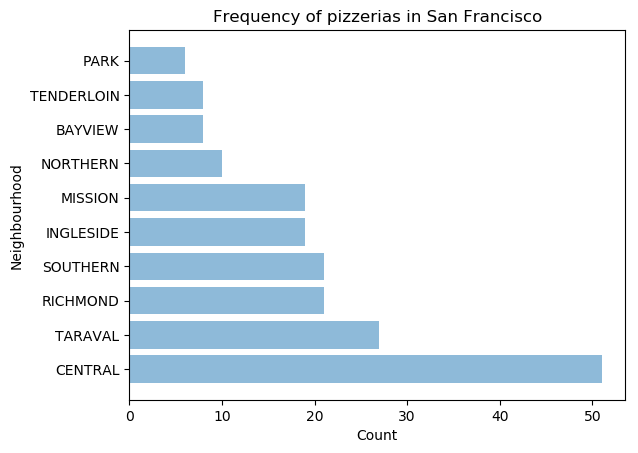

In [72]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt

objects = df_San['Neighbourhood']
y_pos = np.arange(len(df_San))
performance = df_San['Count']

plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('Count')
plt.ylabel('Neighbourhood')
plt.title('Frequency of pizzerias in San Francisco')

plt.show()

### Methodology - Chi Squared goodness of fit test

We will use a Chi Squared Goodness of Fit test to determine which Neighbourhood has statistically the most pizzerias.
This test is used to compare the observed frequency against the expected frequency for a categorical variable.
To determine whether or not some neighbourhoods have mo|re pizzerias, we would test against each neighbourhood having the same number of pizzerias.

Null hypothesis: observed = expected

Alternate hypothesis: observed ≠ expected 

In [93]:
import scipy.stats as stats
from scipy.stats import chi2

In [96]:
observed = df_San['Count']
expected = df_San['Count'].sum() / df_San['Neighbourhood'].count()

stats = (((observed-expected)**2)/expected).sum()

print('Chisq stat =',chi_squared_stat)
print('df =',df_San['Neighbourhood'].count()-1)

crit = chi2.ppf(q = 0.95, df = df_San['Neighbourhood'].count()-1)   
print("Critical value =",crit)

p_value = 1 - chi2.cdf(x=chi_squared_stat, df = df_San['Neighbourhood'].count()-1)
print("P value =",p_value)

Chisq stat = 83.57894736842104
df = 9
Critical value = 16.918977604620448
P value = 3.1308289294429414e-14


### Results 

The above p-value is less than 0.005, so we reject the null hypothesis.
This suggests that not all Neighbourhoods have the same number of pizzerias.

In [97]:
# Your data file was loaded into a botocore.response.StreamingBody object.
# Please read the documentation of ibm_boto3 and pandas to learn more about the possibilities to load the data.
# ibm_boto3 documentation: https://ibm.github.io/ibm-cos-sdk-python/
# pandas documentation: http://pandas.pydata.org/
streaming_body_1 = client_a92d6b46523d4d3c9ab2c34389b755d4.get_object(Bucket='courseracapstone-donotdelete-pr-jozhmuaocmnauk', Key='san-francisco.geojson')['Body']
# add missing __iter__ method so pandas accepts body as file-like object
if not hasattr(streaming_body_1, "__iter__"): streaming_body_1.__iter__ = types.MethodType( __iter__, streaming_body_1 ) 
    
SanFran_Geo = r'san-francisco.geojson'

In [122]:
SanFran_map = folium.Map(location = [37.77,-122.42], zoom_start = 13)

for lat, lng in zip(df['lat'], df['lng']):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5, 
        color='pink',
        fill=True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(SanFran_map)

SanFran_map

After inspecting Table 3 - Frequncy of pizzerias by neighbourhood, and the above map, we are able to conclude that the Central Neighbourhood statistically has the most pizzerias.

### Discussion 

This purpose of this report is to determine the optimal neighbourhood in San Francisco to open a new branch. With data showing the key driving factor for job satisfaction among Data Daddy employees to be proximity to pizzerias, we have analysed data to determine which Neighbourhood in San Francisco has the most pizzerias.

At the beginning of the report we assumed that the Neighbourhood to have the most pizzerias is "Central". Using the Chi Squared Goodness of Fit test, we are able to conclude that this assumption is correct.

### Conclusion

In this report I analysed geospatial data to determine which neighbourhood contains the most pizzerias. With the number of pizzerias being the prime factor in determining where to open a Data Daddy San Francisco branch, I would recommend opening the San Francisco branch in the Central neighbourhood.

This report looks solely at the freqency of pizzerias and narrows down the neighbourhoods in San Francisco. There are many additional data we could leverage off to inform the executives at Data Daddy on possibly another neighbourhood, or a district within the central neighbourhood for a new Data Daddy branch.
Future research could:
- Sample a more comprehensive job satifaction survery prior to this report
- leverage off real time commercial rental properties in the San Francisco area
- Compare the cost of setting up a branch in a  neighbourhood surrounding the central neighbourhood